In [2]:
# Import packages
from __future__ import print_function, division
from IPython.display import display, HTML

import pandas as pd
import numpy as np

from tqdm import tqdm

# import statsmodels.api as sm
from statsmodels import tsa
import statsmodels.api as sm
from datetime import date, datetime, timedelta
import copy
import scipy as sp
from scipy.optimize import fsolve
from scipy.stats import norm
from scipy.optimize import minimize
from scipy import interpolate
import datetime
import scipy
from statsmodels.tsa.arima_model import ARIMA

from cycler import cycler
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
import matplotlib.dates

# Plotting and display options
np.set_printoptions(precision=5)
pd.set_option('precision', 2)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

plt.style.use('ggplot')

mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.color'] = 'blue'
mpl.rcParams['axes.prop_cycle'] = cycler('color', ['#30a2da', '#e5ae38', '#fc4f30', '#6d904f', '#8b8b8b'])
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['axes.facecolor'] = '#f0f0f0'
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['axes.linewidth'] = 1.2
mpl.rcParams['axes.labelpad'] = 0.0
mpl.rcParams['axes.xmargin'] = 0.05  # x margin.  See `axes.Axes.margins`
mpl.rcParams['axes.ymargin'] = 0.05  # y margin See `axes.Axes.margins`
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['figure.subplot.left'] = 0.08
mpl.rcParams['figure.subplot.right'] = 0.95
mpl.rcParams['figure.subplot.bottom'] = 0.07

# figure configuration
fsize = (10,7.5) # figure size
tsize = 18 # title font size
lsize = 16 # legend font size
csize = 14 # comment font size
grid = True # grid

# pandas settings
pd.set_option('precision', 6)
pd.set_option('display.float_format', lambda x: '%.6f' % x)

# this allows plots to appear directly in the notebook
get_ipython().magic(u'matplotlib inline')

In [2]:
def capm(x, y, k, nb_portfolio): # x minus not yet rf
    xx = sm.add_constant(x)    
    nb_factors = sm.add_constant(x).shape[1]
    xx = np.asarray(xx)
    y = np.asarray(y)    
    ols_fit = [sm.OLS(y[:,i]-np.array(rf)[:len(y)],xx).fit() for i in range(nb_portfolio)]
    coef = np.asarray([[ols_fit[i].params[j] for j in range(nb_factors)] for i in range(nb_portfolio)])
    se_r = np.asarray([[ols_fit[i].bse[j] for j in range(nb_factors)] for i in range(nb_portfolio)])
    se_wh = np.asarray([[ols_fit[i].get_robustcov_results(cov_type='HC0').bse[j] for j in range(nb_factors)] for i in range(nb_portfolio)])
    se_nw = np.asarray([[ols_fit[i].get_robustcov_results(cov_type='HAC', maxlags=k).bse[j] for j in range(nb_factors)] for i in range(nb_portfolio)])
    t_test = np.asarray([[ols_fit[i].tvalues[j] for j in range(nb_factors)] for i in range(nb_portfolio)])
    p_value = np.asarray([[ols_fit[i].pvalues[j] for j in range(nb_factors)] for i in range(nb_portfolio)])
    resid = np.asarray([ols_fit[i].resid for i in range(nb_portfolio)])
    
# GRS test
    T = xx.shape[0]
    N = xx.shape[1]
    mu_f = x.mean(axis=0)
    omega = np.cov(x.T)
    alpha = coef[:,0]
    sigma = np.dot(resid,resid.T)/(T-N)
    if N == 2:
        SR2 = mu_f**2/omega
    else:
        SR2 = np.dot(mu_f.T,np.linalg.solve(omega,mu_f))
    
    grs_stat = T*np.dot(alpha.T,np.linalg.solve(sigma,alpha))/(1+SR2)
    p_value_chisq =  1 - scipy.stats.chi2.cdf(grs_stat, 25)
    return coef, se_r, se_wh, se_nw, t_test, p_value, grs_stat, p_value_chisq, resid

def capm_rez(x, y, k, nb_portfolio):
    coef, se_r, se_wh, se_nw, t_test, p_value, chisq_test, p_value_chisq, resid = capm(x, y, k, nb_portfolio)
    lh_tbl = np.empty( (nb_portfolio, coef.shape[1]+1 ) )
    for k in range(nb_portfolio):
        lh_tbl[k,0] = k+1
    headers = ['Portfolio']
    fmts = ['%d']
    for i in range(coef.shape[1]):
        lh_tbl[:,i+1] = coef[:,i]
        if (i==0): headers.append('const')
        else: headers.append(x.columns[i-1])
        fmts.append('%0.2f')
    tbl = sm.iolib.table.SimpleTable(lh_tbl, headers,
        data_fmts=fmts )
    
    print(tbl)
    return coef, se_r, se_wh, se_nw, t_test, p_value, chisq_test, p_value_chisq, resid

def cross_reg(x,y,nb_portfolio):
    y = np.asarray(y)
    yy = np.asarray([np.mean(np.array(y)[:,i]- np.array(rf)[:len(y)]) for i in range(nb_portfolio)])

    coef, se_r, se_wh, se_nw, t_test, p_value, chisq_test, p_value_chisq, resid = capm_rez(fact, r_port, k=10, nb_portfolio=nb_assets)    
    
    ols_cross = sm.OLS(yy,coef[:,1:]).fit(cov_type='HC0')
    LAMDA = np.asarray(ols_cross.params)
    se = np.asarray(ols_cross.HC0_se)
    resid = np.asarray(ols_cross.resid)
    p_value = np.asarray(ols_cross.pvalues)
    
    return LAMDA, se, p_value, resid, ols_cross

### Reference Portfolio Construction

In [7]:
port = pd.read_excel('data.xlsx', index_col=0, header=0, sheetname='Portfolio')
port.head()

,MSCI(DM),MCSI(EM),NZ50,BNDGLB
Date,,,,
2002-12-31,792.220000,292.090000,1024.463875,216.140000
2003-01-31,767.480000,290.440000,1025.251322,217.310000
2003-02-28,752.860000,281.290000,1081.122109,220.370000
2003-03-31,748.630000,272.270000,1117.387083,220.530000
2003-04-30,813.300000,295.170000,1172.927753,222.870000


In [8]:
r_port = (port.iloc[1:,:].values / port.iloc[:-1,:].values - 1)*100
r_port = pd.DataFrame(r_port, index=port.index[1:], columns=port.columns)
r_port.head()

,MSCI(DM),MCSI(EM),NZ50,BNDGLB
Date,,,,
2003-01-31,-3.122870,-0.564894,0.076864,0.541316
2003-02-28,-1.904936,-3.150393,5.449472,1.408127
2003-03-31,-0.561857,-3.206655,3.354383,0.072605
2003-04-30,8.638446,8.410769,4.970585,1.061080
2003-05-31,5.453092,6.867229,8.803082,2.584466


In [9]:
r_port = r_port.T.append(pd.read_excel('data.xlsx',index_col=0, header=0, sheetname='Alternative').T).T
r_port.head()

,MSCI(DM),MCSI(EM),NZ50,BNDGLB,ME1 PRIOR1,ME1 PRIOR2,ME1 PRIOR3,ME1 PRIOR4,ME1 PRIOR5,ME2 PRIOR1,...,ME4 PRIOR5,ME5 PRIOR1,ME5 PRIOR2,ME5 PRIOR3,ME5 PRIOR4,ME5 PRIOR5,IEF,TLT,SHY,LQD
Date,,,,,,,,,,,,,,,,,,,,,
2003-01-31,-3.122870,-0.564894,0.076864,0.541316,-0.740000,-1.000000,-1.970000,0.290000,0.440000,-4.560000,...,-2.370000,-2.530000,-2.520000,-3.610000,-2.670000,-0.310000,85.490000,88.060000,82.250000,108.800000
2003-02-28,-1.904936,-3.150393,5.449472,1.408127,-5.120000,-3.010000,-3.910000,-1.010000,-0.750000,-3.520000,...,0.070000,-0.400000,-2.360000,-0.860000,-2.940000,-0.470000,87.090000,90.470000,82.450000,110.490000
2003-03-31,-0.561857,-3.206655,3.354383,0.072605,0.360000,0.660000,0.530000,1.310000,3.210000,2.520000,...,1.850000,0.210000,0.630000,1.920000,1.050000,1.800000,86.520000,88.900000,82.490000,110.200000
2003-04-30,8.638446,8.410769,4.970585,1.061080,17.380000,11.800000,6.770000,7.640000,7.340000,18.450000,...,6.320000,17.600000,13.490000,6.070000,6.120000,4.540000,86.390000,89.450000,82.510000,112.050000
2003-05-31,5.453092,6.867229,8.803082,2.584466,26.640000,13.090000,10.370000,9.780000,7.330000,20.360000,...,6.990000,11.280000,11.660000,4.620000,2.520000,5.530000,89.310000,94.600000,82.680000,115.550000


In [10]:
nb_assets_ref = 4
nb_assets = 35
capital = 1
weight = np.array([.65,.1,.05,.2]) 
weight = weight/ np.sum(weight)
q = capital*weight/port.iloc[0,:nb_assets_ref]
port['Reference Portfolio Value'] = port.apply(lambda x: np.sum(x[:nb_assets_ref]*q), axis=1) 
port['Reference Portfolio Annual Return'] = np.nan
port['Reference Portfolio Annual Return'].iloc[1:] = port['Reference Portfolio Value'].iloc[1:].values / port['Reference Portfolio Value'].iloc[:-1].values - 1
port.head()

,MSCI(DM),MCSI(EM),NZ50,BNDGLB,Reference Portfolio Value,Reference Portfolio Annual Return
Date,,,,,,
2002-12-31,792.220000,292.090000,1024.463875,216.140000,1.000000,nan
2003-01-31,767.480000,290.440000,1025.251322,217.310000,0.980258,-0.019742
2003-02-28,752.860000,281.290000,1081.122109,220.370000,0.970688,-0.009762
2003-03-31,748.630000,272.270000,1117.387083,220.530000,0.966047,-0.004781
2003-04-30,813.300000,295.170000,1172.927753,222.870000,1.031824,0.068088


In [11]:
port.describe()

,MSCI(DM),MCSI(EM),NZ50,BNDGLB,Reference Portfolio Value,Reference Portfolio Annual Return
count,182.000000,182.000000,182.000000,180.000000,182.000000,181.000000
mean,1373.924670,857.942967,3057.285844,318.345444,1.861552,0.005911
std,316.336980,246.222846,1236.398317,61.672158,0.415003,0.037940
min,748.630000,272.270000,1024.463875,216.140000,0.966047,-0.176218
25%,1141.097500,743.662500,2214.851533,254.040000,1.572837,-0.013156
50%,1336.785000,929.220000,2798.701825,325.685000,1.910387,0.010234
75%,1647.447500,1027.272500,4028.566870,376.347500,2.211344,0.027525
max,2213.240000,1337.450000,6167.318661,408.690000,2.743337,0.088982


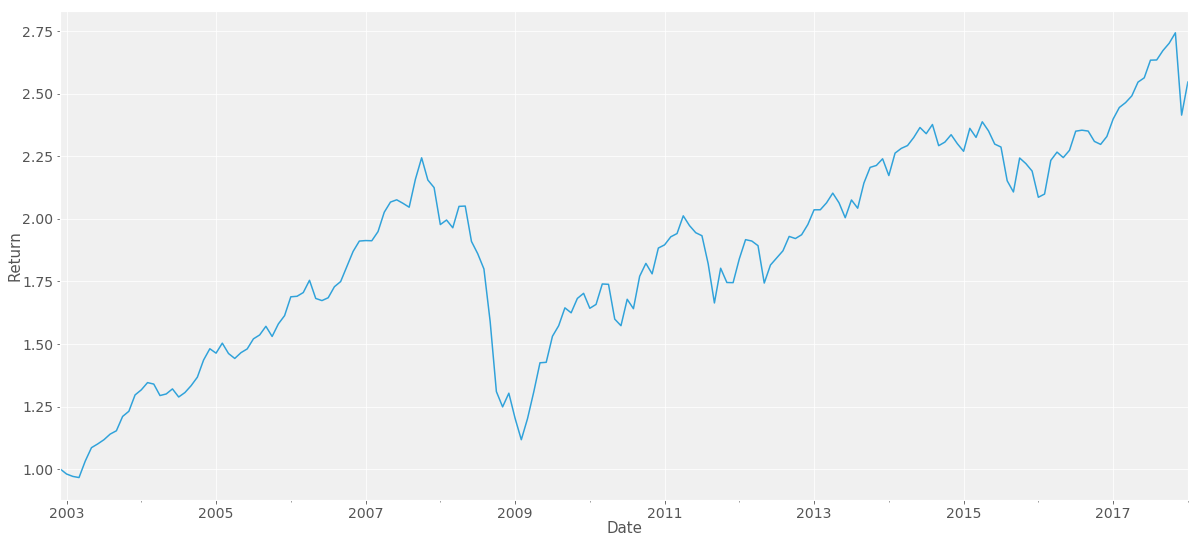

In [12]:
ax = port['Reference Portfolio Value'].plot(figsize=(18,9),rot=0)
ax.set_ylabel("Return")

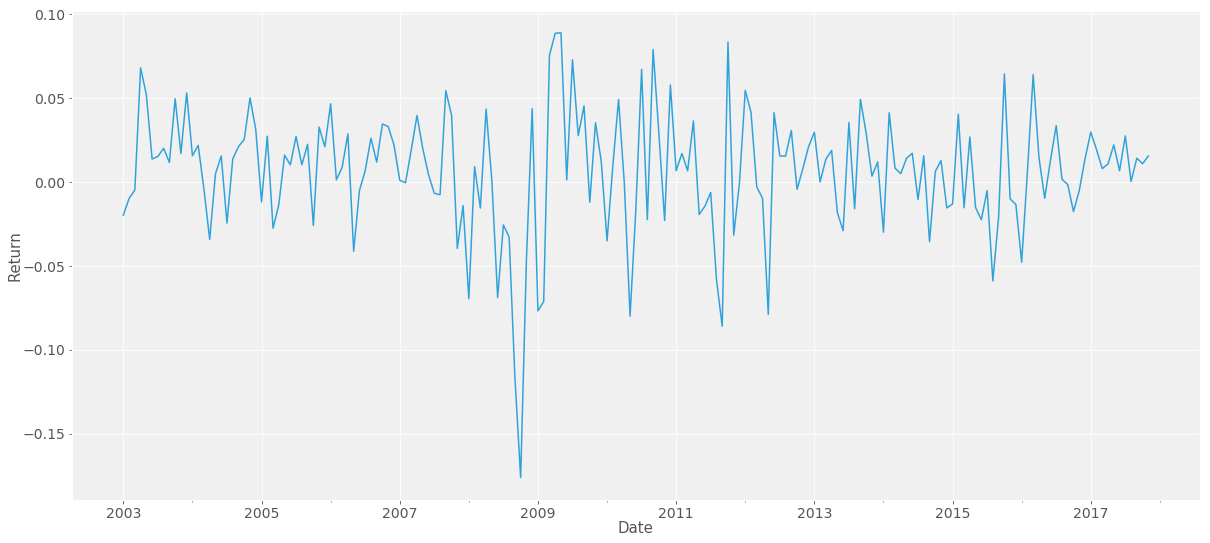

In [8]:
ax = port['Reference Portfolio Annual Return'].plot(figsize=(18,9),rot=0)
ax.set_ylabel("Return")

In [13]:
factor = pd.read_excel('data.xlsx', index_col=0, header=0, sheetname='Factor')
factor.head()

,Mkt-RF,SMB,HML,RMW,CMA,RF,T10Y2Y
Date,,,,,,,
2002-12-31,-5.760000,0.540000,2.250000,6.200000,-1.610000,0.110000,2.190000
2003-01-31,-2.570000,0.830000,-0.930000,-0.610000,0.810000,0.100000,2.310000
2003-02-28,-1.880000,-0.890000,-1.450000,1.110000,-0.540000,0.090000,2.270000
2003-03-31,1.090000,0.580000,-2.090000,1.990000,-0.690000,0.100000,2.240000
2003-04-30,8.220000,1.030000,1.030000,-4.660000,1.140000,0.100000,2.340000


#### Test for the stationarity of factor returns

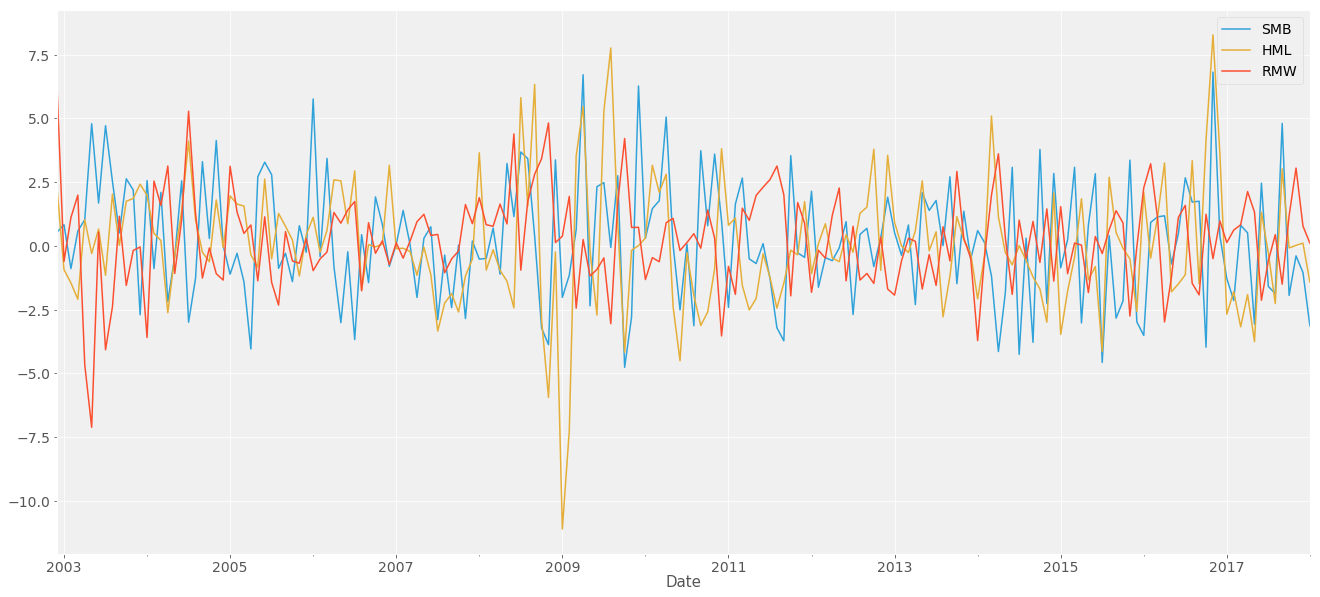

In [16]:
ax = factor.plot(kind='line', y='SMB', figsize=(20,10))
factor.plot(kind='line', y='HML', ax=ax)
factor.plot(kind='line', y='RMW', ax=ax)

In [19]:
from statsmodels.tsa.stattools import adfuller
SMB = factor['SMB']
result = adfuller(SMB)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -15.158612
p-value: 0.000000
Critical Values:
	1%: -3.467
	5%: -2.878
	10%: -2.575


In [20]:
HML = factor['HML']
result = adfuller(HML)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -9.060557
p-value: 0.000000
Critical Values:
	1%: -3.467
	5%: -2.878
	10%: -2.575


In [21]:
RMW = factor['RMW']
result = adfuller(RMW)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -11.648587
p-value: 0.000000
Critical Values:
	1%: -3.467
	5%: -2.878
	10%: -2.575


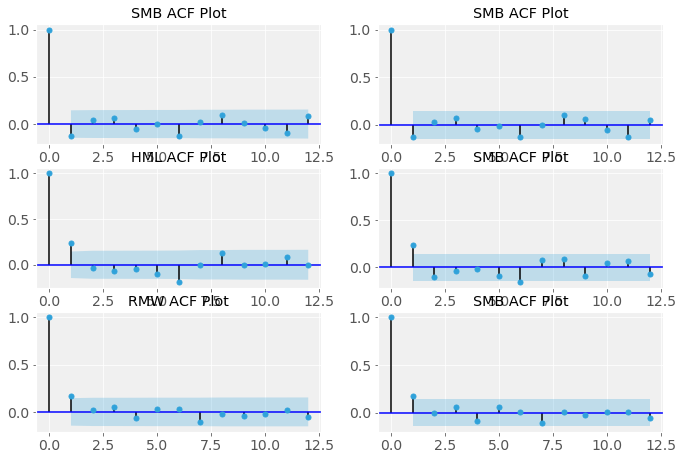

In [37]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=fsize)
ax1= plot_acf(SMB, lags=12, title='SMB ACF Plot', ax=ax[0,0])
ax2=plot_pacf(SMB, lags=12, title='SMB ACF Plot', ax=ax[0,1])
ax3=plot_acf(HML, lags=12, title='HML ACF Plot', ax=ax[1,0])
ax4=plot_pacf(HML, lags=12, title='SMB ACF Plot', ax=ax[1,1])
ax5=plot_acf(RMW, lags=12, title='RMW ACF Plot', ax=ax[2,0])
ax6=plot_pacf(RMW, lags=12, title='SMB ACF Plot', ax=ax[2,1])

In [46]:
X = np.array(SMB.iloc[:-1])
X = sm.add_constant(X)
Y = np.array(SMB.iloc[1:])
model = sm.OLS(Y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     3.029
Date:                Wed, 14 Mar 2018   Prob (F-statistic):             0.0835
Time:                        16:36:50   Log-Likelihood:                -411.53
No. Observations:                 181   AIC:                             827.1
Df Residuals:                     179   BIC:                             833.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2294      0.176      1.300      0.195      -0.119       0.578
x1            -0.1297      0.075     -1.740      0.084      -0.277       0.017
==============================================================================
Omnibus:                        1.572   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.456   Jarque-Bera (JB):                1.660
Skew:                           0.201   Prob(JB):                        0.436
Kurtosis:                       2.758   Cond. No.                         2.38
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
X = np.array(HML.iloc[:-1])
X = sm.add_constant(X)
Y = np.array(HML.iloc[1:])
model = sm.OLS(Y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     11.17
Date:                Wed, 14 Mar 2018   Prob (F-statistic):            0.00101
Time:                        16:37:43   Log-Likelihood:                -413.34
No. Observations:                 181   AIC:                             830.7
Df Residuals:                     179   BIC:                             837.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0292      0.178      0.164      0.870      -0.321       0.380
x1             0.2420      0.072      3.342      0.001       0.099       0.385
==============================================================================
Omnibus:                       15.474   Durbin-Watson:                   1.940
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.395
Skew:                           0.022   Prob(JB):                     1.14e-11
Kurtosis:                       5.585   Cond. No.                         2.45
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [48]:
X = np.array(RMW.iloc[:-1])
X = sm.add_constant(X)
Y = np.array(RMW.iloc[1:])
model = sm.OLS(Y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     5.616
Date:                Wed, 14 Mar 2018   Prob (F-statistic):             0.0189
Time:                        16:38:13   Log-Likelihood:                -355.82
No. Observations:                 181   AIC:                             715.6
Df Residuals:                     179   BIC:                             722.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1516      0.130      1.165      0.246      -0.105       0.408
x1             0.1690      0.071      2.370      0.019       0.028       0.310
==============================================================================
Omnibus:                        8.425   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.015   Jarque-Bera (JB):               10.561
Skew:                          -0.326   Prob(JB):                      0.00509
Kurtosis:                       3.987   Cond. No.                         1.85
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [104]:
def Sharpe_Ratio(df, rebalance=3):
    N = df.shape[0]
    SMB_SR = []
    HML_SR = []
    RMW_SR = []
    index = []
    for i in np.arange(0, N-3, 3):
        j = i+3
        SMB_SR.append(df['SMB'].iloc[i:j].mean()/df['SMB'].iloc[i:j].std())
        HML_SR.append(df['HML'].iloc[i:j].mean()/df['HML'].iloc[i:j].std())
        RMW_SR.append(df['RMW'].iloc[i:j].mean()/df['RMW'].iloc[i:j].std())
        index.append(df.index[j])
    
    d = {'SMB SR': SMB_SR, 'HML SR': HML_SR, 'RMW SR': RMW_SR}
    d = pd.DataFrame(d, index=index, columns=['SMB SR', 'HML SR', 'RMW SR'])
#     mean = pd.rolling_mean(fr-rf, window=window)
#     std = pd.rolling_std(fr-rf, window=window)
#     sharpe = mean/std
#     sharpe = pd.DataFrame(sharpe, columns=['Rolling Sharpe Ratios'])
#     return sharpe
    return d

In [89]:
new_factor = factor.iloc[1:]
new_factor['SMB'] = new_factor['SMB'] - new_factor['RF']
new_factor['HML'] = new_factor['HML'] - new_factor['RF']
new_factor['RMW'] = new_factor['RMW'] - new_factor['RF']
new_factor.head()

/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

,Mkt-RF,SMB,HML,RMW,CMA,RF,T10Y2Y
Date,,,,,,,
2003-01-31,-2.570000,0.630000,-1.130000,-0.810000,0.810000,0.100000,2.310000
2003-02-28,-1.880000,-1.070000,-1.630000,0.930000,-0.540000,0.090000,2.270000
2003-03-31,1.090000,0.380000,-2.290000,1.790000,-0.690000,0.100000,2.240000
2003-04-30,8.220000,0.830000,0.830000,-4.860000,1.140000,0.100000,2.340000
2003-05-31,6.050000,4.610000,-0.480000,-7.290000,3.220000,0.090000,2.150000


In [105]:
SR = Sharpe_Ratio(new_factor, rebalance=3)
SR

,SMB SR,HML SR,RMW SR
2003-04-30,-0.021789,-2.893140,0.480653
2003-07-31,1.141322,0.399792,-1.009945
2003-10-31,1.154607,0.095228,-0.719520
2004-01-31,0.188554,5.355969,-0.889922
2004-04-30,0.599056,0.776165,0.010107
2004-07-31,-0.067041,-0.343957,0.420454
2004-10-31,-0.165428,0.629031,0.471836
2005-01-31,0.522919,0.075285,-1.550876
2005-04-30,-2.074180,5.396606,0.932550
2005-07-31,0.048637,0.014282,-0.185058


In [108]:
mean = pd.rolling_mean(SR, window=2)
std = pd.rolling_std(SR, window=2)
persistency = mean/std
persistency

/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=2,center=False).mean()
  """Entry point for launching an IPython kernel.
/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=2,center=False).std()
  


,SMB SR,HML SR,RMW SR
2003-04-30,nan,nan,nan
2003-07-31,0.680613,-0.535408,-0.251085
2003-10-31,122.209850,1.149291,-4.210785
2004-01-31,0.983133,0.732706,-6.678628
2004-04-30,1.356693,0.946782,-0.691226
2004-07-31,0.564770,0.272843,0.741940
2004-10-31,-1.670746,0.207174,12.279465
2005-01-31,0.367234,0.899378,-0.377215
2005-04-30,-0.422359,0.727115,-0.176056
2005-07-31,-0.674705,0.710859,0.472935


In [72]:
SMB_3m = Sharpe_Rolling(SMB, RF, window=3)
SMB_LT = Sharpe_Rolling(SMB, RF, window=36)*6/13 + Sharpe_Rolling(SMB, RF, window=24)*4/13 + Sharpe_Rolling(SMB, RF, window=12)*2/13 + Sharpe_Rolling(SMB, RF, window=6)/13

/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=3,center=False).mean()
  
/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=3,center=False).std()
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=36,center=False).mean()
  
/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.roll

In [73]:
HML_3m = Sharpe_Rolling(HML, RF, window=3)
HML_LT = Sharpe_Rolling(HML, RF, window=36)*6/13 + Sharpe_Rolling(HML, RF, window=24)*4/13 + Sharpe_Rolling(HML, RF, window=12)*2/13 + Sharpe_Rolling(HML, RF, window=6)/13

/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=3,center=False).mean()
  
/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=3,center=False).std()
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=36,center=False).mean()
  
/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.roll

In [74]:
RMW_3m = Sharpe_Rolling(RMW, RF, window=3)
RMW_LT = Sharpe_Rolling(RMW, RF, window=36)*6/13 + Sharpe_Rolling(RMW, RF, window=24)*4/13 + Sharpe_Rolling(RMW, RF, window=12)*2/13 + Sharpe_Rolling(RMW, RF, window=6)/13

/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=3,center=False).mean()
  
/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=3,center=False).std()
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=36,center=False).mean()
  
/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.roll

In [78]:
Signal = factor[36:]
Signal['SMB_3m'] = SMB_3m[36:]
Signal['SMB_LT'] = SMB_LT[36:]
Signal['HML_3m'] = HML_3m[36:]
Signal['HML_LT'] = HML_LT[36:]
Signal['RMW_3m'] = RMW_3m[36:]
Signal['RMW_LT'] = RMW_LT[36:]

/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [59]:
RF = factor['RF']
SMB_SR = Sharpe_Rolling(SMB, RF, window=3)
SMB_SR.head()

/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=3,center=False).mean()
  
/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=3,center=False).std()
  This is separate from the ipykernel package so we can avoid doing imports until


,Rolling Sharpe Ratios
Date,
2002-12-31,nan
2003-01-31,nan
2003-02-28,0.065712
2003-03-31,0.083009
2003-04-30,0.143546


In [61]:
SMB_SR_6m = Sharpe_Rolling(SMB, RF, window=6)
SMB_SR_6m

/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=6,center=False).mean()
  
/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=6,center=False).std()
  This is separate from the ipykernel package so we can avoid doing imports until


,Rolling Sharpe Ratios
Date,
2002-12-31,nan
2003-01-31,nan
2003-02-28,nan
2003-03-31,nan
2003-04-30,nan
2003-05-31,0.548430
2003-06-30,0.654458
2003-07-31,0.818585
2003-08-31,1.344546


In [9]:
def simpleRebalanceStrategy(tab_,weight_,nb_assets_,freq_=3,capital_=1):
    tab_['Rebalanced Reference Portfolio Value'] = tab_['Reference Portfolio Value']
    cap = capital_
    q = cap*weight_/tab_.iloc[0,:nb_assets_]
    for i in range(1,tab_.shape[0]): 
        if ((i+1)%freq_==0):
            cap = tab_['Rebalanced Reference Portfolio Value'].iloc[i-1]
            q = cap*weight_/tab_.iloc[i,:nb_assets_]
        tab_['Rebalanced Reference Portfolio Value'].iloc[i] = np.sum(tab_.iloc[i,:nb_assets_]*q)
    return tab_           

In [10]:
port = simpleRebalanceStrategy(port,weight_=weight,nb_assets_=nb_assets_ref,freq_=3,capital_=1)
port['Rebalanced Reference Portfolio Annual Return'] = np.nan
port['Rebalanced Reference Portfolio Annual Return'].iloc[1:] = \
    port['Rebalanced Reference Portfolio Value'].iloc[1:].values / port['Rebalanced Reference Portfolio Value'].iloc[:-1].values - 1
port.head()

,MSCI(DM),MCSI(EM),NZ50,BNDGLB,Reference Portfolio Value,Reference Portfolio Annual Return,Rebalanced Reference Portfolio Value,Rebalanced Reference Portfolio Annual Return
Date,,,,,,,,
2002-12-31,792.220000,292.090000,1024.463875,216.140000,1.000000,nan,1.000000,nan
2003-01-31,767.480000,290.440000,1025.251322,217.310000,0.980258,-0.019742,0.980258,-0.019742
2003-02-28,752.860000,281.290000,1081.122109,220.370000,0.970688,-0.009762,0.980258,0.000000
2003-03-31,748.630000,272.270000,1117.387083,220.530000,0.966047,-0.004781,0.975321,-0.005036
2003-04-30,813.300000,295.170000,1172.927753,222.870000,1.031824,0.068088,1.042633,0.069015


In [11]:
port.describe()
# SR = 0.072028/0.137079 = 0.5254488287775662

,MSCI(DM),MCSI(EM),NZ50,BNDGLB,Reference Portfolio Value,Reference Portfolio Annual Return,Rebalanced Reference Portfolio Value,Rebalanced Reference Portfolio Annual Return
count,180.000000,180.000000,180.000000,180.000000,180.000000,179.000000,180.000000,179.000000
mean,1365.208889,854.069889,3023.754737,318.345444,1.854676,0.006341,1.656548,0.005647
std,306.923582,244.754082,1201.157730,61.672158,0.412039,0.036786,0.444956,0.029805
min,748.630000,272.270000,1024.463875,216.140000,0.966047,-0.176218,0.975321,-0.160336
25%,1138.847500,741.860000,2211.993892,254.040000,1.572237,-0.012597,1.253336,0.000000
50%,1334.995000,928.615000,2777.962914,325.685000,1.902796,0.010234,1.553833,0.000000
75%,1636.542500,1021.527500,4003.122606,376.347500,2.194455,0.027435,2.101126,0.015756
max,2077.360000,1337.450000,5874.550724,408.690000,2.743337,0.088982,2.529532,0.090103


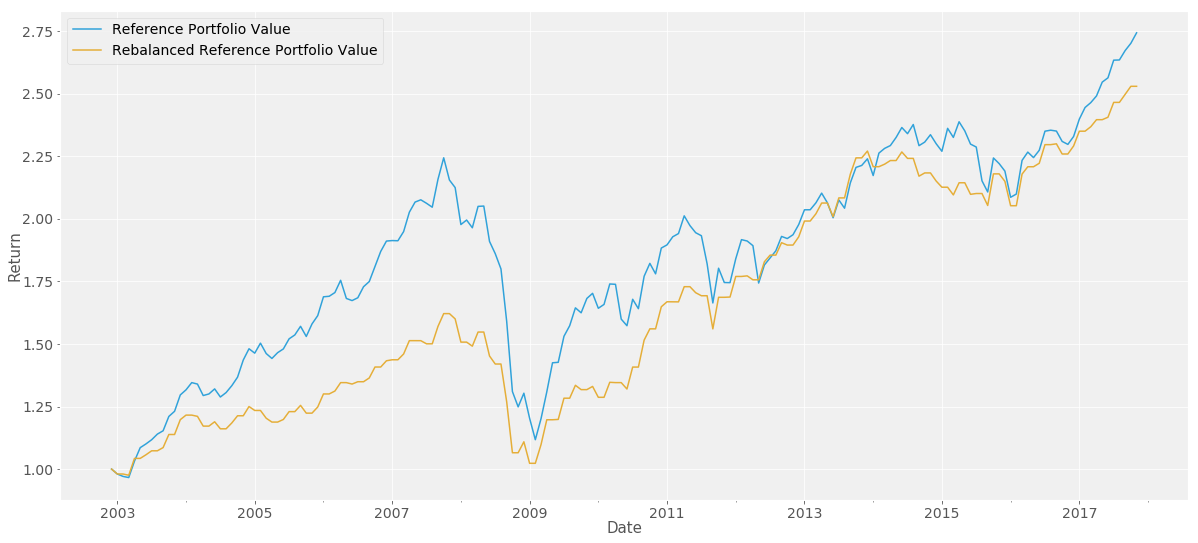

In [12]:
ax = port[['Reference Portfolio Value','Rebalanced Reference Portfolio Value']].plot(figsize=(18,9))
ax.set_ylabel("Return")

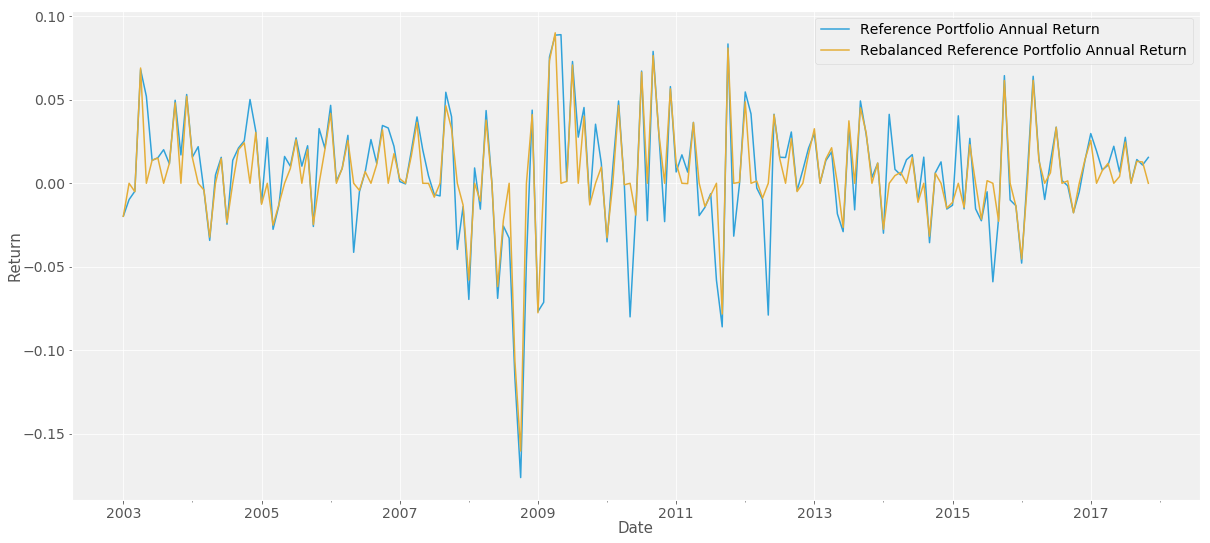

In [13]:
ax = port[['Reference Portfolio Annual Return','Rebalanced Reference Portfolio Annual Return']].plot(figsize=(18,9))
ax.set_ylabel("Return")

### Factor Analysis

In [14]:
fact = pd.read_excel('T:/Berkeley/courses/230K_dynamic_asset_management/Project/data.xlsx',index_col=0, header=0, sheet_name='Factor')
rf = fact['RF']
del fact['RF']
fact.head()

,Mkt-RF,SMB,HML,RMW,CMA,T10Y2Y,Bullish Sentiment,Credit Spread,Inflation,VIX
Date,,,,,,,,,,
2003-01-31,-2.570000,0.830000,-0.930000,-0.610000,0.810000,2.310000,0.300460,2.540000,0.200000,31.170000
2003-02-28,-1.880000,-0.890000,-1.450000,1.110000,-0.540000,2.270000,0.229575,2.470000,0.400000,29.629999
2003-03-31,1.090000,0.580000,-2.090000,1.990000,-0.690000,2.240000,0.374750,2.460000,0.300000,29.150000
2003-04-30,8.220000,1.030000,1.030000,-4.660000,1.140000,2.340000,0.450275,2.160000,0.100000,21.209999
2003-05-31,6.050000,4.790000,-0.300000,-7.110000,3.220000,2.150000,0.530960,1.930000,0.100000,19.469999


In [15]:
coef, se_r, se_wh, se_nw, t_test, p_value, chisq_test, p_value_chisq, resid = capm_rez(fact, r_port, k=10, nb_portfolio=nb_assets)

Portfolio const Mkt-RF  SMB   HML   RMW   CMA  T10Y2Y Bullish Sentiment Credit Spread Inflation  VIX 
-----------------------------------------------------------------------------------------------------
    1     -1.17  1.01  -0.20  0.02 -0.07 -0.14 -0.15         3.12            0.25       -0.18   -0.03
    2     -3.15  1.25  -0.06 -0.01  0.05 -0.71 -1.07         7.82            0.44        0.01    0.04
    3     -0.04  0.70  -0.29  0.08 -0.33  0.11  0.30        -0.57            0.35        1.65   -0.03
    4      0.20  0.09  -0.12 -0.06  0.02  0.06  0.09        -1.31            0.05       -0.58    0.02
    5     -6.64  1.21   0.91  0.60 -0.77 -0.45 -0.26         8.91            1.57        1.09   -0.00
    6     -1.60  0.97   0.95  0.35 -0.16 -0.25  0.17         2.03            0.38        0.05   -0.02
    7      0.53  0.87   0.87  0.25 -0.10 -0.11  0.25        -0.31           -0.12       -0.70   -0.01
    8      0.40  0.80   0.88  0.07 -0.13  0.11  0.13         0.80            0.10 

In [16]:
coef_tab = pd.DataFrame(coef,columns=['const','Mkt-RF','SMB','HML','RMW','CMA',
                              'T10Y2Y','Bullish Sentiment','Credit Spread','Inflation','VIX'])

temp = abs(coef_tab.iloc[:,1:]).apply(np.argmax, axis=0)
temp

C:\Users\Yi\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


Mkt-RF               24
SMB                   8
HML                   9
RMW                   4
CMA                   1
T10Y2Y                1
Bullish Sentiment     4
Credit Spread         4
Inflation            30
VIX                  24
dtype: int64

In [17]:
alter = []
for i,j in zip(temp,coef_tab.columns[1:]):
    alter.append((abs(coef_tab.iloc[:,1:])/coef_tab.iloc[:,1:]).iloc[i][j] * i)
alter

[24.0, 8.0, 9.0, -4.0, -1.0, -1.0, 4.0, 4.0, -30.0, 24.0]

### Valuation Investment Strategy

In [18]:
fact_in_sample = fact.loc[:'2010-12']
fact_in_sample.head()

,Mkt-RF,SMB,HML,RMW,CMA,T10Y2Y,Bullish Sentiment,Credit Spread,Inflation,VIX
Date,,,,,,,,,,
2003-01-31,-2.570000,0.830000,-0.930000,-0.610000,0.810000,2.310000,0.300460,2.540000,0.200000,31.170000
2003-02-28,-1.880000,-0.890000,-1.450000,1.110000,-0.540000,2.270000,0.229575,2.470000,0.400000,29.629999
2003-03-31,1.090000,0.580000,-2.090000,1.990000,-0.690000,2.240000,0.374750,2.460000,0.300000,29.150000
2003-04-30,8.220000,1.030000,1.030000,-4.660000,1.140000,2.340000,0.450275,2.160000,0.100000,21.209999
2003-05-31,6.050000,4.790000,-0.300000,-7.110000,3.220000,2.150000,0.530960,1.930000,0.100000,19.469999


In [19]:
fact_out_sample = fact.loc['2011-01':]
fact_out_sample.head()

,Mkt-RF,SMB,HML,RMW,CMA,T10Y2Y,Bullish Sentiment,Credit Spread,Inflation,VIX
Date,,,,,,,,,,
2011-01-31,1.990000,-2.410000,0.810000,-0.800000,0.690000,2.780000,0.502525,2.050000,0.200000,19.530001
2011-02-28,3.490000,1.640000,1.090000,-1.900000,0.940000,2.810000,0.460375,1.930000,0.400000,18.350000
2011-03-31,0.450000,2.660000,-1.550000,1.480000,0.000000,2.710000,0.361600,1.920000,0.300000,17.740000
2011-04-30,2.900000,-0.510000,-2.510000,1.000000,-0.830000,2.730000,0.389750,1.860000,0.200000,14.750000
2011-05-31,-1.270000,-0.690000,-2.060000,1.980000,-1.490000,2.610000,0.296325,1.900000,0.200000,15.450000


In [20]:
LAMDA, se, p_value, resid, ols_cross = cross_reg(fact,r_port,nb_portfolio=nb_assets)

Portfolio const Mkt-RF  SMB   HML   RMW   CMA  T10Y2Y Bullish Sentiment Credit Spread Inflation  VIX 
-----------------------------------------------------------------------------------------------------
    1     -1.17  1.01  -0.20  0.02 -0.07 -0.14 -0.15         3.12            0.25       -0.18   -0.03
    2     -3.15  1.25  -0.06 -0.01  0.05 -0.71 -1.07         7.82            0.44        0.01    0.04
    3     -0.04  0.70  -0.29  0.08 -0.33  0.11  0.30        -0.57            0.35        1.65   -0.03
    4      0.20  0.09  -0.12 -0.06  0.02  0.06  0.09        -1.31            0.05       -0.58    0.02
    5     -6.64  1.21   0.91  0.60 -0.77 -0.45 -0.26         8.91            1.57        1.09   -0.00
    6     -1.60  0.97   0.95  0.35 -0.16 -0.25  0.17         2.03            0.38        0.05   -0.02
    7      0.53  0.87   0.87  0.25 -0.10 -0.11  0.25        -0.31           -0.12       -0.70   -0.01
    8      0.40  0.80   0.88  0.07 -0.13  0.11  0.13         0.80            0.10 

In [30]:
def rebalanceStrategy(tab_,weight_,nb_assets_,freq_=3,capital_=1):
    tab_['Rebalanced Portfolio Annual Return'] = tab_['Rebalanced Reference Portfolio Annual Return']
    cap = capital_
    w = weight_
    for i in range(tab_.iloc[port.index <= '2011'].shape[0]+1,tab_.shape[0]):
        if ((i+1)%freq_==0):
            coef, se_r, se_wh, se_nw, t_test, p_value, chisq_test, p_value_chisq, resid = \
                                            capm_rez(fact.iloc[:(i-1)], r_port.iloc[:(i-1)], k=10, nb_portfolio=nb_assets_)
            LAMDA, se, p_value, resid, ols_cross = cross_reg(fact.iloc[:(i-1)],r_port.iloc[:(i-1)],nb_portfolio=nb_assets_)
            pos_adj = alter[np.argmax(abs(LAMDA))]
            premium_sign = abs(LAMDA[np.argmax(LAMDA)])/LAMDA[np.argmax(LAMDA)]
            w2 = copy.deepcopy(w)
            if pos_adj*premium_sign > 0: 
                pos_adj = abs(int(pos_adj))
                if pos_adj in [1,2,3,4]:
                    for j in range(4):
                        if j == pos_adj-1: w2[j] = w2[j]+.05
                        else: w2[j] = w2[j]-.05/3
                else: 
                    w2[pos_adj-1] = w2[pos_adj-1]+.05
                    for j in range(4):
                        w2[j] = w2[j]-.05/4
#                 for j in range(len(w2)):
#                     if j == pos_adj-1: w2[j] = w2[j]+.05
#                     if w2[j]>0: 
#                         w2[j] = w2[j]-.05/(np.sum(w2>0))
            print(i)
            tab_['Rebalanced Portfolio Annual Return'].iloc[i] =  w2.dot(r_port.iloc[i-1])
        else:
            tab_['Rebalanced Portfolio Annual Return'].iloc[i] =  w2.dot(r_port.iloc[i-1])
    return tab_    

In [32]:
port = rebalanceStrategy(port,weight_=np.append(weight,np.repeat(0,nb_assets-nb_assets_ref)),
                         nb_assets_=nb_assets,freq_=3,capital_=1)

Portfolio const Mkt-RF  SMB   HML   RMW   CMA  T10Y2Y Bullish Sentiment Credit Spread Inflation  VIX 
-----------------------------------------------------------------------------------------------------
    1     -0.67  1.02  -0.21  0.00 -0.06 -0.13 -0.04         2.81            0.32       -0.25   -0.05
    2     -0.35  1.28  -0.01 -0.13 -0.31 -1.14 -0.66         4.38            0.41       -2.28   -0.01
    3      3.58  0.69  -0.51  0.22 -0.79 -0.52  0.76        -7.29            0.12        0.24   -0.04
    4      0.50  0.10  -0.16  0.02 -0.05  0.01  0.08        -1.73            0.02       -1.09    0.03
    5     -8.91  1.27   0.83  0.73 -1.05 -0.69 -0.34        12.06            1.50        1.74    0.06
    6     -2.03  0.97   0.91  0.39 -0.34 -0.31  0.17         2.33            0.46        0.79   -0.02
    7     -0.44  0.86   0.81  0.21 -0.13 -0.09  0.33         1.96            0.14        0.04   -0.05
    8     -1.01  0.82   0.87 -0.07 -0.09  0.11  0.21         3.85            0.24 

In [36]:
port['Rebalanced Portfolio Value'] = np.nan
port['Rebalanced Portfolio Value'].iloc[:1] = port['Rebalanced Reference Portfolio Value'].iloc[:1]
port['Rebalanced Portfolio Value'].iloc[1:] = np.cumprod(port['Rebalanced Portfolio Annual Return'].iloc[1:]+1)
port.loc['2011']

,MSCI(DM),MCSI(EM),NZ50,BNDGLB,Reference Portfolio Value,Reference Portfolio Annual Return,Rebalanced Reference Portfolio Value,Rebalanced Reference Portfolio Annual Return,Rebalanced Portfolio Annual Return,Rebalanced Portfolio Value
Date,,,,,,,,,,
2011-01-31,1308.080000,1119.080000,2600.019143,337.860000,1.895908,0.006767,1.668504,0.012119,0.012119,1.668504
2011-02-28,1351.650000,1107.770000,2587.455244,338.970000,1.928198,0.017031,1.668504,-0.000000,2.391956,5.659494
2011-03-31,1334.920000,1170.870000,2679.969854,339.540000,1.941117,0.006700,1.668129,-0.000225,0.021959,5.783769
2011-04-30,1388.620000,1204.030000,2873.233549,345.960000,2.011903,0.036466,1.728762,0.036348,3.579738,26.488147
2011-05-31,1354.610000,1167.970000,2840.750811,349.070000,1.972945,-0.019364,1.728762,0.000000,-1.805761,-21.343111
2011-06-30,1331.180000,1146.220000,2815.995862,348.490000,1.944530,-0.014402,1.704779,-0.013873,-1.328927,7.020322
2011-07-31,1306.050000,1137.730000,2921.310897,355.290000,1.932437,-0.006219,1.692616,-0.007135,-0.943673,0.395436
2011-08-31,1211.220000,1033.150000,2855.555319,360.280000,1.820235,-0.058062,1.692616,0.000000,-5.759642,-1.882133
2011-09-30,1104.070000,880.430000,2536.078205,359.550000,1.663768,-0.085960,1.560113,-0.078283,-8.090575,13.345401


### Rebalancing Strategy

In [ ]:
cons = ({'type': 'ineq',
         'fun' : lambda x: np.sum(x.dot(coef[:,2:]))-1},
       {'type': 'eq',
         'fun' : lambda x: np.sum(x.dot(coef[:,1]))},
       {'type': 'eq',
         'fun' : lambda x: np.sum(x)-1})

In [ ]:
def rebalanceStrategy(tab_,weight_,nb_assets_,option_,freq_=3):
    tab_['Rebalanced Portfolio Annual Return'] = tab_['Reference Portfolio Annual Return']
    w = weight_
    
    def obj_fun(weight__):
        r_port_ = weight__.dot(r_mean)
        risk_port_ = weight__.dot(r_var).dot(weight__)    
        if(option_=='Maximize Sharpe Ratio'): 
            return -r_port_/risk_port_
        elif(option_=='Minimize Variance'): 
            return risk_port_

    for i in range(1,r_port.shape[0]): 
        if ((i+1)%freq_==0):
            r_mean = r_port.iloc[:i].mean()
            r_var = r_port.iloc[:i].cov()
            w = minimize(obj_fun, x0=w, constraints=cons, bounds=[(-1,1) for i in range(nb_assets)]).x  
            print(w)
        tab_['Rebalanced Portfolio Annual Return'].iloc[i] = w.dot(r_port.iloc[i])
    return tab_            

In [ ]:
port = rebalanceStrategy(port,weight_=np.repeat(1/nb_assets,nb_assets),nb_assets_=nb_assets,option_='Maximize Sharpe Ratio',freq_=3)
port['Rebalanced Portfolio Value'] = np.nan
port['Rebalanced Portfolio Value'].iloc[0] = 1
port['Rebalanced Portfolio Value'].iloc[1:] = np.cumprod(port['Rebalanced Portfolio Annual Return'].iloc[1:]*.01+1)
port.head()

In [ ]:
ax = port[['Rebalanced Portfolio Value','Rebalanced Reference Portfolio Value']].plot(figsize=(18,9),rot=0)
ax.set_ylabel("Value")

In [ ]:
port.describe()